# Testing reconGan





## Setup imports

In [20]:
import os

import matplotlib.pyplot as plt
import numpy as np

from monai.data import partition_dataset, CacheDataset
from monai.data import DataLoader
from monai.apps import DecathlonDataset
from monai.transforms import (
    MapTransform,
    Randomizable,
    AddChanneld,
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch

from tqdm import tqdm

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import SelectChanneld
from utils2 import RandZF

from networks import ResUnetGenerator
#############################################

# set determinism for reproducibility
set_determinism(seed=0)


root_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/'

device = torch.device("cuda:0")

# Create datasets

## Baseline pipeline

In [4]:
class RandConcatd(MapTransform, Randomizable):

    """Transform to concatenate one slice into two channels """

    def __init__(self, keys, seed: int = None, allow_missing_keys: bool = False):

        Randomizable.set_random_state(self, seed=seed)
        MapTransform.__init__(self, keys, allow_missing_keys)

    def __call__(self, data):
        """
        Args:
            data (Mapping): dictionary to transform. Arrays must
                be torch tensors.   
        """

        d = dict(data)
        c = self.R.randint(25,35)

        for key in self.key_iterator(d):
            s = d[key][0,:,:,c][None,:]
            d[key] = torch.cat([s,s])
        return d

In [5]:
val_transform = Compose(
    [
        LoadImaged(keys="image"),
        AsChannelFirstd(keys="image"),
        SelectChanneld("image", 0),
        Spacingd(
            keys="image",
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        Orientationd(keys="image", axcodes="RAS"),
        CenterSpatialCropd(keys="image", roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys="image"),
        RandConcatd("image"),
        ]
)

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    num_workers=4,
    cache_num= 1 # 4
)

# Batch size during training
batch_size = 4

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


## Check data shape and visualize

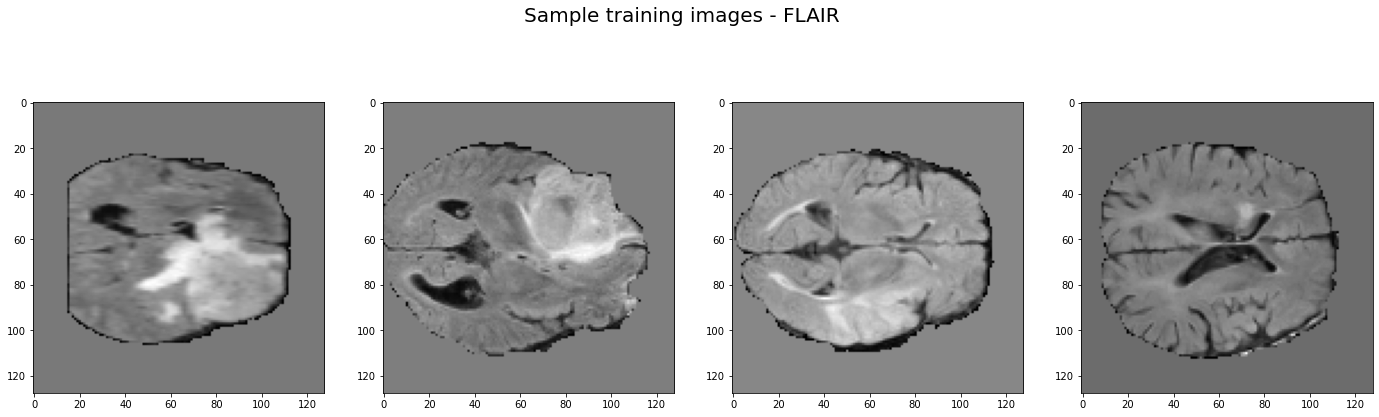

In [10]:
plt.figure(figsize=(24,7))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.suptitle("Sample training images - FLAIR", size = 20)
    plt.imshow(val_ds[i]['image'][0, :, :], cmap="gray")
plt.show()

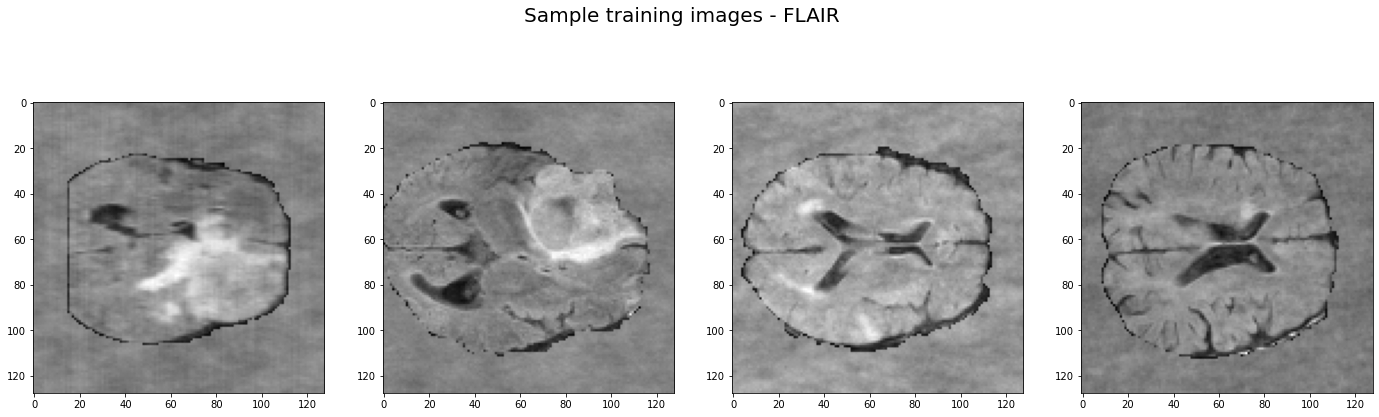

In [12]:
compress = RandZF(p = 0.2)

plt.figure(figsize=(24,7))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = compress(val_ds[i]['image'])
    plt.suptitle("Sample training images - FLAIR", size = 20)
    plt.imshow(img[0, :, :], cmap="gray")
plt.show()

In [23]:
G = ResUnetGenerator(2,16).to(device)
G.load_state_dict(torch.load('/vol/bitbucket/yc7620/90_data/90_recon/reconGan_G_epochs200.pth'))

<All keys matched successfully>

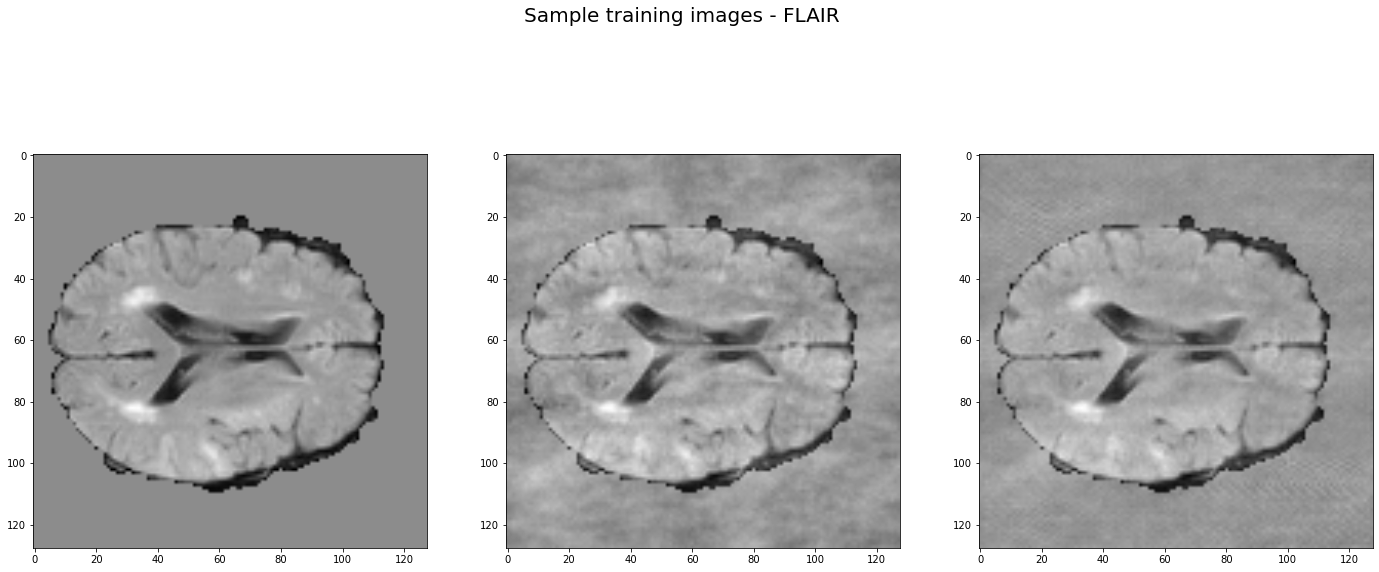

In [42]:
n = 2

plt.figure(figsize=(24,10))

plt.subplot(1,3,1)
img = (val_ds[n]['image'])
# img = val_ds[n]['image']
plt.imshow(img[0], cmap='gray', interpolation='bilinear')

plt.subplot(1,3,2)
img = compress(val_ds[n]['image'])
# img = val_ds[n]['image']
plt.imshow(img[0], cmap='gray', interpolation='bilinear')

plt.subplot(1,3,3)
img = img[None,:].to(device)
img = G(img)
plt.suptitle("Sample training images - FLAIR", size = 20)
plt.imshow(img[0,0, :, :].detach().cpu(), cmap="gray", interpolation='bilinear')
plt.show()

In [38]:
img.size()

torch.Size([1, 2, 128, 128])